 <h1><center> <font color='green'>CNN  Basado en TL Inception V3 </font></center></h1> 

 <h1><center> <font color='blue'>Librerías</font></center></h1> 


In [1]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [64]:
pip install pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
"""Importar librerias para realizar CNN"""
import os
"""Cargar las imagenes"""
import cv2
from PIL import Image
"""Tensoflow para las redes neuronales"""
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
"""Librería para calculo numerico"""
import numpy as np
"""Libreria para graficas"""
import matplotlib.pyplot as plt
"""Importa para dividir el conjunto de datos en entrenamiento y prueba"""
from sklearn.model_selection import train_test_split
"""Librería que que ofrece metricas"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
"""Importa datos de señales de registro de archivos de ejecuciones
de simulación disponibles para la aplicación en tiempo real seleccionadas"""
from PIL import Image
import time
import math
import logging

<h1><center> <font color='orange'>Carga y exploración de datos</font></center></h1> 

In [3]:
"""Definición del tamaño, array de las imagenes"""
IMG_SHAPE  = 224
batch_size = 32
random_seed = 9

In [4]:
# Carga de datos
fpath = './DataSetClasificado_Recortado'
categories = os.listdir(fpath)
print("List of categories = ", categories, "\n\nNo. of categories = ", len(categories))

List of categories =  ['FASE 0', 'FASE 1', 'FASE 2', 'FASE 3', 'FASE 4', 'FASE 5', 'FASE 6'] 

No. of categories =  7


In [ ]:
"""Funcion para cargar las imagenes por categorias"""
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')

            img_lst.append(np.array(img_array))

            labels.append(index)
    return img_lst, labels
"""Cargar las imagenes desde las categorias"""
images, labels = load_images_and_labels(categories)
"""Mostrar la cantidad de imagenes cargadas"""
print("Nº de imágenes cargadas = ",len(images),"\nNo. de etiquetas cargadas = ",len(labels))
print(type(images),type(labels))

In [ ]:
"""Variables para ver el array de las imagenes y los label"""
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

In [ ]:
"""Función para visualizar imagenes aleatorias """
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
 
        plt.title('Fase: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
"""Mostrar imagenes con sus labels"""
display_rand_images(images, labels)

# TEST

In [ ]:
"""Definición del tamaño, array de las imagenes"""
IMG_SHAPE  = 224
batch_size = 32
random_seed = 9

In [ ]:
# Carpeta de prueba
fpath_test = './DataSet_Test'
# Categorías de prueba
categories_test = os.listdir(fpath_test)
print("List of categories (test) =", categories_test, "\n\nNo. of categories =", len(categories_test))

In [ ]:
"""Funcion para cargar las imagenes de prueba"""
def load_test_images(categories):
    img_lst = []
    labels = []
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath_test+"/"+category):
            img = cv2.imread(fpath_test+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
            img_lst.append(np.array(img_array))
            labels.append(index)
    return img_lst, labels

"""Cargar las imagenes de prueba desde las categorias de prueba"""
test_images, test_labels = load_test_images(categories_test)

"""Mostrar la cantidad de imagenes de prueba cargadas"""
print("Nº de imágenes de prueba cargadas =", len(test_images), "\nNo. de etiquetas de prueba cargadas =", len(test_labels))
print(type(test_images), type(test_labels))

In [ ]:
"""Variables para ver el array de las imagenes de prueba y los label"""
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Test images shape =", test_images.shape, "\nTest labels shape =", test_labels.shape)
print(type(test_images), type(test_labels))

In [ ]:

# Función para visualizar imagenes aleatorias
def display_rand_images(test_images, test_labels):
    plt.figure(1, figsize=(19, 10))
    n = 0
    for i in range(9):
        n += 1
        r = np.random.randint(0, test_images.shape[0], 1)
        
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        plt.imshow(test_images[r[0]])
        plt.title('Fase: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

# Mostrar imagenes con sus labels
display_rand_images(test_images, test_labels)

<h1>Definición del conjunto de datos para pruebas y entrenamiento

In [ ]:
"""Primero se reorganizan los datos"""

"""Obtener números igualmente espaciados en un rango dado"""
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

"""Mezclar todos los valores igualmente espaciados en la lista 'n'"""
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

In [ ]:
"""El segundo paso es la mezcla de datos"""

"""imágenes aleatorias y datos de etiquetas correspondientes en ambas listas"""
images = images[n]
labels = labels[n]

print("Forma de las imágenes después de la mezcla = ",images.shape,"\nForma de las etiquetas después de mezclar= ",labels.shape)

### Normalización

In [ ]:
"""Normalizacion de los datos, segun su tipo: float, int"""
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Forma de las imágenes después de la normalización = ",images.shape)

### Training and Testing

In [ ]:
'''Se divide el conjunto de datos en 80% para entrenamiento y 20% para prueba'''
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

"""Mostrar los array en cada parte del entrenamiento y la prueba"""

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

In [ ]:
"""Estructura One-hot-encode"""
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)
y_val = to_categorical(y_val, 7)

In [89]:
import os
import cv2
import numpy as np

# Función para crear variaciones de una imagen
def generar_variaciones(imagen, cantidad=10):
    variaciones = []
    h, w, _ = imagen.shape

    for _ in range(cantidad):
        # Aplicar transformaciones aleatorias
        angulo = np.random.uniform(-10, 10)
        escala = np.random.uniform(0.8, 1.2)
        traslacion_x = np.random.randint(-20, 20)
        traslacion_y = np.random.randint(-20, 20)

        matriz_rotacion = cv2.getRotationMatrix2D((w / 2, h / 2), angulo, escala)
        matriz_traslacion = np.float32([[1, 0, traslacion_x], [0, 1, traslacion_y]])

        imagen_variada = cv2.warpAffine(imagen, matriz_rotacion, (w, h))
        imagen_variada = cv2.warpAffine(imagen_variada, matriz_traslacion, (w, h))

        variaciones.append(imagen_variada)

    return variaciones

# Ruta del dataset
dataset_path = "./DataSetClasificado_Recortado"

# Directorio de salida para las imágenes generadas
output_dir = "./ImagenesGeneradas"

# Crear directorio de salida si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generar imágenes para el dataset
for fase in range(7):
    fase_path = os.path.join(dataset_path, f"Fase {fase}")
    if not os.path.isdir(fase_path):
        continue
    
    for imagen_file in os.listdir(fase_path):
        imagen_path = os.path.join(fase_path, imagen_file)

        # Cargar imagen original
        imagen_original = cv2.imread(imagen_path)

        # Generar variaciones
        variaciones = generar_variaciones(imagen_original)

        # Guardar imágenes generadas
        nombre_imagen_base = os.path.splitext(imagen_file)[0]  # Nombre base de la imagen sin extensión
        output_fase_path = os.path.join(output_dir, f"Fase {fase}")
        if not os.path.exists(output_fase_path):
            os.makedirs(output_fase_path)
        
        for i, variacion in enumerate(variaciones):
            nombre_imagen = f"{nombre_imagen_base}_generada_{i}.png"
            nombre_imagen_path = os.path.join(output_fase_path, nombre_imagen)
            cv2.imwrite(nombre_imagen_path, variacion)

print("Generación de imágenes completada.")


Generación de imágenes completada.



 <h1><center> <font color='purple'>Implementación del modelo CNN Basado en TL Inception V3</font></center></h1> 

In [26]:
"""Función para el pre-entrenamiento del modelo, con InceptionV3"""
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=x_train[0].shape, include_top=False, weights="imagenet")


In [27]:
"""Pre-entrenar el modelo por capas"""
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_2
conv2d_94
batch_normalization_94
activation_94
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
max_pooling2d_4
conv2d_97
batch_normalization_97
activation_97
conv2d_98
batch_normalization_98
activation_98
max_pooling2d_5
conv2d_102
batch_normalization_102
activation_102
conv2d_100
conv2d_103
batch_normalization_100
batch_normalization_103
activation_100
activation_103
average_pooling2d_9
conv2d_99
conv2d_101
conv2d_104
conv2d_105
batch_normalization_99
batch_normalization_101
batch_normalization_104
batch_normalization_105
activation_99
activation_101
activation_104
activation_105
mixed0
conv2d_109
batch_normalization_109
activation_109
conv2d_107
conv2d_110
batch_normalization_107
batch_normalization_110
activation_107
activation_110
average_pooling2d_10
conv2d_106
conv2d_108
conv2d_111
conv2d_112
batch_normalization_106
batch_normalization_108
batch_normalization_111
batch_normalization_112
activation_106
activation_108
activation

# GridSearchCV

In [67]:
from sklearn.model_selection import GridSearchCV,KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
def create_model(dropout_rate,units ):
  
  last_layer = pre_trained_model.get_layer('mixed10')
  last_output = last_layer.output
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)


  x = tf.keras.layers.Dense(units= units, activation='relu')(x)
  x = tf.keras.layers.Dense(units= units, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)

  x = tf.keras.layers.Dense(units= units, activation='relu')(x)
  x = tf.keras.layers.Dense(units= units, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)


  x = tf.keras.layers.Dense(7, activation='softmax')(x)
  model_GridSearchCV = tf.keras.Model(pre_trained_model.input, x)
  """Configuracion para compilar el modelo, tambien se optimiza"""
  model_GridSearchCV.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])
  return model_GridSearchCV



model_GridSearchCV = KerasClassifier(build_fn = create_model)

C:\Users\Fabián\AppData\Local\Temp\ipykernel_1360\3877328018.py:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_GridSearchCV = KerasClassifier(build_fn = create_model)


In [69]:
batch_size = [32,40,64]
epochs = [25]
#learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.1,0.2,0.3,0.4,0.5]
#activation_function = ['softmax','relu','tanh','linear']
#init = ['uniform']
units = [512,1004,350,784,256,128]
neuron1 = [128,256]
neuron2 = [128,256]


param_grids = dict(batch_size = batch_size,epochs = epochs,dropout_rate = dropout_rate,
                   units = units)



grid = GridSearchCV(estimator = model_GridSearchCV,param_grid = param_grids,cv = 2,verbose = 1)
grid_result = grid.fit(x_train, y_train)

Fitting 2 folds for each of 90 candidates, totalling 180 fits
Epoch 1/25
14/14 [==============================] - 23s 1s/step - loss: 1.3866 - acc: 0.5704
Epoch 2/25
14/14 [==============================] - 17s 1s/step - loss: 0.6556 - acc: 0.7900
Epoch 3/25
14/14 [==============================] - 17s 1s/step - loss: 0.4002 - acc: 0.8520
Epoch 4/25
14/14 [==============================] - 17s 1s/step - loss: 0.3307 - acc: 0.8807
Epoch 5/25
14/14 [==============================] - 18s 1s/step - loss: 0.3281 - acc: 0.8783
Epoch 6/25
14/14 [==============================] - 17s 1s/step - loss: 0.3277 - acc: 0.8687
Epoch 7/25
14/14 [==============================] - 17s 1s/step - loss: 0.2737 - acc: 0.9117
Epoch 8/25
14/14 [==============================] - 17s 1s/step - loss: 0.1645 - acc: 0.9523
Epoch 9/25
14/14 [==============================] - 17s 1s/step - loss: 0.1226 - acc: 0.9618
Epoch 10/25
14/14 [==============================] - 17s 1s/step - loss: 0.1369 - acc: 0.9594
Epoch 1

14/14 [==============================] - 19s 1s/step - loss: 0.1485 - acc: 0.9618
Epoch 20/25
14/14 [==============================] - 19s 1s/step - loss: 0.1322 - acc: 0.9547
Epoch 21/25
14/14 [==============================] - 19s 1s/step - loss: 0.1530 - acc: 0.9547
Epoch 22/25
14/14 [==============================] - 19s 1s/step - loss: 0.1914 - acc: 0.9379
Epoch 23/25
14/14 [==============================] - 19s 1s/step - loss: 0.1496 - acc: 0.9547
Epoch 24/25
14/14 [==============================] - 19s 1s/step - loss: 0.0839 - acc: 0.9833
Epoch 25/25
14/14 [==============================] - 20s 1s/step - loss: 1.7241 - acc: 0.6229
Epoch 1/25
14/14 [==============================] - 26s 1s/step - loss: 1.4221 - acc: 0.5680
Epoch 2/25
14/14 [==============================] - 20s 1s/step - loss: 0.7896 - acc: 0.7542
Epoch 3/25
14/14 [==============================] - 24s 2s/step - loss: 0.4452 - acc: 0.8544
Epoch 4/25
14/14 [==============================] - 24s 2s/step - loss: 0.3

14/14 [==============================] - 17s 1s/step - loss: 0.6926 - acc: 0.7470
Epoch 4/25
14/14 [==============================] - 17s 1s/step - loss: 0.5729 - acc: 0.7995
Epoch 5/25
14/14 [==============================] - 17s 1s/step - loss: 0.4757 - acc: 0.8234
Epoch 6/25
14/14 [==============================] - 17s 1s/step - loss: 0.4093 - acc: 0.8783
Epoch 7/25
14/14 [==============================] - 17s 1s/step - loss: 0.3714 - acc: 0.8807
Epoch 8/25
14/14 [==============================] - 17s 1s/step - loss: 0.3669 - acc: 0.8807
Epoch 9/25
14/14 [==============================] - 17s 1s/step - loss: 0.2908 - acc: 0.8878
Epoch 10/25
14/14 [==============================] - 17s 1s/step - loss: 0.2421 - acc: 0.9260
Epoch 11/25
14/14 [==============================] - 17s 1s/step - loss: 0.1993 - acc: 0.9451
Epoch 12/25
14/14 [==============================] - 17s 1s/step - loss: 0.2663 - acc: 0.9117
Epoch 13/25
14/14 [==============================] - 17s 1s/step - loss: 0.217

14/14 [==============================] - 17s 1s/step - loss: 0.2065 - acc: 0.9260
Epoch 14/25
14/14 [==============================] - 17s 1s/step - loss: 0.1394 - acc: 0.9523
Epoch 15/25
14/14 [==============================] - 17s 1s/step - loss: 0.1677 - acc: 0.9427
Epoch 16/25
14/14 [==============================] - 17s 1s/step - loss: 0.1754 - acc: 0.9475
Epoch 17/25
14/14 [==============================] - 17s 1s/step - loss: 0.1652 - acc: 0.9427
Epoch 18/25
14/14 [==============================] - 17s 1s/step - loss: 0.2055 - acc: 0.9236
Epoch 19/25
14/14 [==============================] - 17s 1s/step - loss: 0.1543 - acc: 0.9499
Epoch 20/25
14/14 [==============================] - 17s 1s/step - loss: 0.0973 - acc: 0.9690
Epoch 21/25
14/14 [==============================] - 17s 1s/step - loss: 0.1112 - acc: 0.9594
Epoch 22/25
14/14 [==============================] - 17s 1s/step - loss: 0.1043 - acc: 0.9737
Epoch 23/25
14/14 [==============================] - 17s 1s/step - loss:

14/14 [==============================] - 17s 1s/step - loss: 0.3146 - acc: 0.8950
Epoch 7/25
14/14 [==============================] - 17s 1s/step - loss: 0.3148 - acc: 0.8783
Epoch 8/25
14/14 [==============================] - 17s 1s/step - loss: 0.2331 - acc: 0.9069
Epoch 9/25
14/14 [==============================] - 17s 1s/step - loss: 0.2661 - acc: 0.9069
Epoch 10/25
14/14 [==============================] - 17s 1s/step - loss: 0.1466 - acc: 0.9618
Epoch 11/25
14/14 [==============================] - 17s 1s/step - loss: 0.1584 - acc: 0.9570
Epoch 12/25
14/14 [==============================] - 17s 1s/step - loss: 0.1996 - acc: 0.9332
Epoch 13/25
14/14 [==============================] - 17s 1s/step - loss: 0.2036 - acc: 0.9403
Epoch 14/25
14/14 [==============================] - 17s 1s/step - loss: 0.2004 - acc: 0.9356
Epoch 15/25
14/14 [==============================] - 17s 1s/step - loss: 0.1917 - acc: 0.9260
Epoch 16/25
14/14 [==============================] - 17s 1s/step - loss: 0.

Epoch 16/25
14/14 [==============================] - 17s 1s/step - loss: 0.2829 - acc: 0.8950
Epoch 17/25
14/14 [==============================] - 17s 1s/step - loss: 0.2345 - acc: 0.9189
Epoch 18/25
14/14 [==============================] - 17s 1s/step - loss: 0.2541 - acc: 0.8902
Epoch 19/25
14/14 [==============================] - 17s 1s/step - loss: 0.2144 - acc: 0.9260
Epoch 20/25
14/14 [==============================] - 17s 1s/step - loss: 0.2504 - acc: 0.9117
Epoch 21/25
14/14 [==============================] - 17s 1s/step - loss: 0.2286 - acc: 0.9189
Epoch 22/25
14/14 [==============================] - 17s 1s/step - loss: 0.1786 - acc: 0.9427
Epoch 23/25
14/14 [==============================] - 17s 1s/step - loss: 0.1529 - acc: 0.9427
Epoch 24/25
14/14 [==============================] - 17s 1s/step - loss: 0.1582 - acc: 0.9499
Epoch 25/25
14/14 [==============================] - 18s 1s/step - loss: 0.7786 - acc: 0.7613
Epoch 1/25
14/14 [==============================] - 23s 1s/s

14/14 [==============================] - 16s 1s/step - loss: 0.1701 - acc: 0.9475
Epoch 10/25
14/14 [==============================] - 16s 1s/step - loss: 0.2089 - acc: 0.9284
Epoch 11/25
14/14 [==============================] - 16s 1s/step - loss: 0.2049 - acc: 0.9308
Epoch 12/25
14/14 [==============================] - 16s 1s/step - loss: 0.1817 - acc: 0.9356
Epoch 13/25
14/14 [==============================] - 16s 1s/step - loss: 0.1836 - acc: 0.9475
Epoch 14/25
14/14 [==============================] - 16s 1s/step - loss: 0.1428 - acc: 0.9427
Epoch 15/25
14/14 [==============================] - 16s 1s/step - loss: 0.2140 - acc: 0.9308
Epoch 16/25
14/14 [==============================] - 16s 1s/step - loss: 0.2031 - acc: 0.9332
Epoch 17/25
14/14 [==============================] - 16s 1s/step - loss: 0.1261 - acc: 0.9570
Epoch 18/25
14/14 [==============================] - 16s 1s/step - loss: 0.1616 - acc: 0.9523
Epoch 19/25
14/14 [==============================] - 16s 1s/step - loss:

14/14 [==============================] - 17s 1s/step - loss: 0.9135 - acc: 0.6611
Epoch 3/25
14/14 [==============================] - 16s 1s/step - loss: 0.8562 - acc: 0.6993
Epoch 4/25
14/14 [==============================] - 16s 1s/step - loss: 0.6476 - acc: 0.7566
Epoch 5/25
14/14 [==============================] - 16s 1s/step - loss: 0.4925 - acc: 0.8210
Epoch 6/25
14/14 [==============================] - 16s 1s/step - loss: 0.4623 - acc: 0.8186
Epoch 7/25
14/14 [==============================] - 16s 1s/step - loss: 0.4707 - acc: 0.8496
Epoch 8/25
14/14 [==============================] - 16s 1s/step - loss: 0.3741 - acc: 0.8735
Epoch 9/25
14/14 [==============================] - 16s 1s/step - loss: 0.2670 - acc: 0.8998
Epoch 10/25
14/14 [==============================] - 16s 1s/step - loss: 0.3282 - acc: 0.8878
Epoch 11/25
14/14 [==============================] - 16s 1s/step - loss: 0.2383 - acc: 0.9069
Epoch 12/25
14/14 [==============================] - 16s 1s/step - loss: 0.1990

14/14 [==============================] - 16s 1s/step - loss: 0.4248 - acc: 0.8353
Epoch 13/25
14/14 [==============================] - 16s 1s/step - loss: 0.3469 - acc: 0.8831
Epoch 14/25
14/14 [==============================] - 16s 1s/step - loss: 0.3753 - acc: 0.8687
Epoch 15/25
14/14 [==============================] - 16s 1s/step - loss: 0.3846 - acc: 0.8544
Epoch 16/25
14/14 [==============================] - 16s 1s/step - loss: 0.4014 - acc: 0.8449
Epoch 17/25
14/14 [==============================] - 16s 1s/step - loss: 0.2730 - acc: 0.9021
Epoch 18/25
14/14 [==============================] - 16s 1s/step - loss: 0.2622 - acc: 0.9021
Epoch 19/25
14/14 [==============================] - 16s 1s/step - loss: 0.2207 - acc: 0.9332
Epoch 20/25
14/14 [==============================] - 16s 1s/step - loss: 0.2073 - acc: 0.9308
Epoch 21/25
14/14 [==============================] - 16s 1s/step - loss: 0.2662 - acc: 0.8998
Epoch 22/25
14/14 [==============================] - 16s 1s/step - loss:

14/14 [==============================] - 16s 1s/step - loss: 0.8579 - acc: 0.7017
Epoch 6/25
14/14 [==============================] - 16s 1s/step - loss: 0.7781 - acc: 0.7041
Epoch 7/25
14/14 [==============================] - 16s 1s/step - loss: 0.6614 - acc: 0.7566
Epoch 8/25
14/14 [==============================] - 16s 1s/step - loss: 0.6653 - acc: 0.7327
Epoch 9/25
14/14 [==============================] - 16s 1s/step - loss: 0.6500 - acc: 0.7613
Epoch 10/25
14/14 [==============================] - 16s 1s/step - loss: 0.5283 - acc: 0.7947
Epoch 11/25
14/14 [==============================] - 16s 1s/step - loss: 0.4911 - acc: 0.8210
Epoch 12/25
14/14 [==============================] - 16s 1s/step - loss: 0.4568 - acc: 0.8425
Epoch 13/25
14/14 [==============================] - 16s 1s/step - loss: 0.4085 - acc: 0.8640
Epoch 14/25
14/14 [==============================] - 16s 1s/step - loss: 0.4680 - acc: 0.8258
Epoch 15/25
14/14 [==============================] - 16s 1s/step - loss: 0.4

Epoch 15/25
14/14 [==============================] - 17s 1s/step - loss: 0.3026 - acc: 0.9021
Epoch 16/25
14/14 [==============================] - 17s 1s/step - loss: 0.3586 - acc: 0.8950
Epoch 17/25
14/14 [==============================] - 17s 1s/step - loss: 0.3188 - acc: 0.8974
Epoch 18/25
14/14 [==============================] - 17s 1s/step - loss: 0.3268 - acc: 0.9045
Epoch 19/25
14/14 [==============================] - 17s 1s/step - loss: 0.2072 - acc: 0.9236
Epoch 20/25
14/14 [==============================] - 17s 1s/step - loss: 0.2267 - acc: 0.9117
Epoch 21/25
14/14 [==============================] - 17s 1s/step - loss: 0.1967 - acc: 0.9332
Epoch 22/25
14/14 [==============================] - 17s 1s/step - loss: 0.1716 - acc: 0.9308
Epoch 23/25
14/14 [==============================] - 17s 1s/step - loss: 0.1748 - acc: 0.9308
Epoch 24/25
14/14 [==============================] - 17s 1s/step - loss: 0.1492 - acc: 0.9499
Epoch 25/25
14/14 [==============================] - 17s 1s/

14/14 [==============================] - 16s 1s/step - loss: 0.7111 - acc: 0.7399
Epoch 9/25
14/14 [==============================] - 16s 1s/step - loss: 0.7254 - acc: 0.7446
Epoch 10/25
14/14 [==============================] - 16s 1s/step - loss: 0.6685 - acc: 0.7470
Epoch 11/25
14/14 [==============================] - 16s 1s/step - loss: 0.7044 - acc: 0.7375
Epoch 12/25
14/14 [==============================] - 16s 1s/step - loss: 0.6124 - acc: 0.8019
Epoch 13/25
14/14 [==============================] - 16s 1s/step - loss: 0.5281 - acc: 0.7947
Epoch 14/25
14/14 [==============================] - 16s 1s/step - loss: 0.5012 - acc: 0.8162
Epoch 15/25
14/14 [==============================] - 16s 1s/step - loss: 0.4781 - acc: 0.8210
Epoch 16/25
14/14 [==============================] - 16s 1s/step - loss: 0.4674 - acc: 0.8138
Epoch 17/25
14/14 [==============================] - 16s 1s/step - loss: 0.4449 - acc: 0.8186
Epoch 18/25
14/14 [==============================] - 16s 1s/step - loss: 

Epoch 18/25
11/11 [==============================] - 17s 1s/step - loss: 0.0209 - acc: 0.9905
Epoch 19/25
11/11 [==============================] - 16s 1s/step - loss: 0.0119 - acc: 0.9976
Epoch 20/25
11/11 [==============================] - 16s 1s/step - loss: 0.0063 - acc: 0.9976
Epoch 21/25
11/11 [==============================] - 16s 1s/step - loss: 0.0043 - acc: 1.0000
Epoch 22/25
11/11 [==============================] - 16s 1s/step - loss: 0.0029 - acc: 1.0000
Epoch 23/25
11/11 [==============================] - 16s 1s/step - loss: 0.0039 - acc: 0.9976
Epoch 24/25
11/11 [==============================] - 16s 1s/step - loss: 0.0021 - acc: 1.0000
Epoch 25/25
11/11 [==============================] - 19s 2s/step - loss: 0.8434 - acc: 0.8067
Epoch 1/25
11/11 [==============================] - 23s 1s/step - loss: 1.3151 - acc: 0.5561
Epoch 2/25
11/11 [==============================] - 16s 1s/step - loss: 0.4753 - acc: 0.8210
Epoch 3/25
11/11 [==============================] - 16s 1s/ste

11/11 [==============================] - 16s 1s/step - loss: 0.0943 - acc: 0.9737
Epoch 12/25
11/11 [==============================] - 16s 1s/step - loss: 0.0976 - acc: 0.9594
Epoch 13/25
11/11 [==============================] - 16s 1s/step - loss: 0.0851 - acc: 0.9618
Epoch 14/25
11/11 [==============================] - 16s 1s/step - loss: 0.0736 - acc: 0.9666
Epoch 15/25
11/11 [==============================] - 16s 1s/step - loss: 0.1465 - acc: 0.9547
Epoch 16/25
11/11 [==============================] - 16s 1s/step - loss: 0.0759 - acc: 0.9737
Epoch 17/25
11/11 [==============================] - 16s 1s/step - loss: 0.0420 - acc: 0.9857
Epoch 18/25
11/11 [==============================] - 16s 1s/step - loss: 0.0921 - acc: 0.9785
Epoch 19/25
11/11 [==============================] - 16s 1s/step - loss: 0.0717 - acc: 0.9785
Epoch 20/25
11/11 [==============================] - 16s 1s/step - loss: 0.0411 - acc: 0.9809
Epoch 21/25
11/11 [==============================] - 16s 1s/step - loss:

11/11 [==============================] - 16s 1s/step - loss: 0.2837 - acc: 0.9045
Epoch 5/25
11/11 [==============================] - 16s 1s/step - loss: 0.2485 - acc: 0.9189
Epoch 6/25
11/11 [==============================] - 16s 1s/step - loss: 0.2240 - acc: 0.9260
Epoch 7/25
11/11 [==============================] - 17s 1s/step - loss: 0.0976 - acc: 0.9737
Epoch 8/25
11/11 [==============================] - 16s 1s/step - loss: 0.1032 - acc: 0.9690
Epoch 9/25
11/11 [==============================] - 16s 1s/step - loss: 0.0579 - acc: 0.9737
Epoch 10/25
11/11 [==============================] - 17s 1s/step - loss: 0.0782 - acc: 0.9737
Epoch 11/25
11/11 [==============================] - 17s 1s/step - loss: 0.1584 - acc: 0.9547
Epoch 12/25
11/11 [==============================] - 17s 1s/step - loss: 0.1891 - acc: 0.9403
Epoch 13/25
11/11 [==============================] - 17s 2s/step - loss: 0.2148 - acc: 0.9379
Epoch 14/25
11/11 [==============================] - 17s 2s/step - loss: 0.17

11/11 [==============================] - 16s 1s/step - loss: 0.0363 - acc: 0.9881
Epoch 15/25
11/11 [==============================] - 16s 1s/step - loss: 0.0228 - acc: 0.9952
Epoch 16/25
11/11 [==============================] - 16s 1s/step - loss: 0.0140 - acc: 0.9928
Epoch 17/25
11/11 [==============================] - 16s 1s/step - loss: 0.0200 - acc: 0.9952
Epoch 18/25
11/11 [==============================] - 16s 1s/step - loss: 0.0192 - acc: 0.9976
Epoch 19/25
11/11 [==============================] - 16s 1s/step - loss: 0.0392 - acc: 0.9928
Epoch 20/25
11/11 [==============================] - 16s 1s/step - loss: 0.0444 - acc: 0.9857
Epoch 21/25
11/11 [==============================] - 16s 1s/step - loss: 0.0600 - acc: 0.9833
Epoch 22/25
11/11 [==============================] - 16s 1s/step - loss: 0.0391 - acc: 0.9857
Epoch 23/25
11/11 [==============================] - 16s 1s/step - loss: 0.0435 - acc: 0.9833
Epoch 24/25
11/11 [==============================] - 16s 1s/step - loss:

11/11 [==============================] - 16s 1s/step - loss: 0.1363 - acc: 0.9594
Epoch 8/25
11/11 [==============================] - 16s 1s/step - loss: 0.1360 - acc: 0.9594
Epoch 9/25
11/11 [==============================] - 16s 1s/step - loss: 0.1104 - acc: 0.9714
Epoch 10/25
11/11 [==============================] - 16s 1s/step - loss: 0.1075 - acc: 0.9690
Epoch 11/25
11/11 [==============================] - 16s 1s/step - loss: 0.0706 - acc: 0.9785
Epoch 12/25
11/11 [==============================] - 16s 1s/step - loss: 0.0602 - acc: 0.9809
Epoch 13/25
11/11 [==============================] - 16s 1s/step - loss: 0.0299 - acc: 0.9905
Epoch 14/25
11/11 [==============================] - 16s 1s/step - loss: 0.0497 - acc: 0.9761
Epoch 15/25
11/11 [==============================] - 16s 1s/step - loss: 0.0909 - acc: 0.9761
Epoch 16/25
11/11 [==============================] - 16s 1s/step - loss: 0.0527 - acc: 0.9857
Epoch 17/25
11/11 [==============================] - 16s 1s/step - loss: 0

Epoch 17/25
11/11 [==============================] - 16s 1s/step - loss: 0.0426 - acc: 0.9833
Epoch 18/25
11/11 [==============================] - 16s 1s/step - loss: 0.0285 - acc: 0.9905
Epoch 19/25
11/11 [==============================] - 17s 1s/step - loss: 0.0414 - acc: 0.9833
Epoch 20/25
11/11 [==============================] - 16s 1s/step - loss: 0.0708 - acc: 0.9785
Epoch 21/25
11/11 [==============================] - 16s 1s/step - loss: 0.0849 - acc: 0.9666
Epoch 22/25
11/11 [==============================] - 16s 1s/step - loss: 0.1050 - acc: 0.9714
Epoch 23/25
11/11 [==============================] - 16s 1s/step - loss: 0.1301 - acc: 0.9547
Epoch 24/25
11/11 [==============================] - 16s 1s/step - loss: 0.0700 - acc: 0.9690
Epoch 25/25
11/11 [==============================] - 18s 1s/step - loss: 8.4999 - acc: 0.2912
Epoch 1/25
11/11 [==============================] - 21s 1s/step - loss: 1.8459 - acc: 0.3723
Epoch 2/25
11/11 [==============================] - 16s 1s/st

11/11 [==============================] - 16s 1s/step - loss: 0.4441 - acc: 0.8282
Epoch 11/25
11/11 [==============================] - 16s 1s/step - loss: 0.3171 - acc: 0.8878
Epoch 12/25
11/11 [==============================] - 16s 1s/step - loss: 0.2968 - acc: 0.9141
Epoch 13/25
11/11 [==============================] - 16s 1s/step - loss: 0.2120 - acc: 0.9260
Epoch 14/25
11/11 [==============================] - 16s 1s/step - loss: 0.1978 - acc: 0.9308
Epoch 15/25
11/11 [==============================] - 16s 1s/step - loss: 0.1214 - acc: 0.9714
Epoch 16/25
11/11 [==============================] - 16s 1s/step - loss: 0.1424 - acc: 0.9570
Epoch 17/25
11/11 [==============================] - 16s 1s/step - loss: 0.1054 - acc: 0.9714
Epoch 18/25
11/11 [==============================] - 16s 1s/step - loss: 0.0775 - acc: 0.9809
Epoch 19/25
11/11 [==============================] - 16s 1s/step - loss: 0.0794 - acc: 0.9809
Epoch 20/25
11/11 [==============================] - 16s 1s/step - loss:

11/11 [==============================] - 16s 1s/step - loss: 0.6589 - acc: 0.7375
Epoch 4/25
11/11 [==============================] - 16s 1s/step - loss: 0.4817 - acc: 0.8210
Epoch 5/25
11/11 [==============================] - 16s 1s/step - loss: 0.4055 - acc: 0.8568
Epoch 6/25
11/11 [==============================] - 16s 1s/step - loss: 0.3495 - acc: 0.8831
Epoch 7/25
11/11 [==============================] - 16s 1s/step - loss: 0.2122 - acc: 0.9260
Epoch 8/25
11/11 [==============================] - 16s 1s/step - loss: 0.1541 - acc: 0.9499
Epoch 9/25
11/11 [==============================] - 16s 1s/step - loss: 0.1760 - acc: 0.9356
Epoch 10/25
11/11 [==============================] - 16s 1s/step - loss: 0.1662 - acc: 0.9403
Epoch 11/25
11/11 [==============================] - 16s 1s/step - loss: 0.1725 - acc: 0.9499
Epoch 12/25
11/11 [==============================] - 16s 1s/step - loss: 0.1034 - acc: 0.9499
Epoch 13/25
11/11 [==============================] - 16s 1s/step - loss: 0.092

11/11 [==============================] - 16s 1s/step - loss: 0.1513 - acc: 0.9523
Epoch 14/25
11/11 [==============================] - 16s 1s/step - loss: 0.1057 - acc: 0.9714
Epoch 15/25
11/11 [==============================] - 16s 1s/step - loss: 0.1108 - acc: 0.9499
Epoch 16/25
11/11 [==============================] - 16s 1s/step - loss: 0.0518 - acc: 0.9833
Epoch 17/25
11/11 [==============================] - 16s 1s/step - loss: 0.0911 - acc: 0.9666
Epoch 18/25
11/11 [==============================] - 16s 1s/step - loss: 0.0766 - acc: 0.9714
Epoch 19/25
11/11 [==============================] - 16s 1s/step - loss: 0.0747 - acc: 0.9809
Epoch 20/25
11/11 [==============================] - 16s 1s/step - loss: 0.0603 - acc: 0.9737
Epoch 21/25
11/11 [==============================] - 16s 1s/step - loss: 0.0491 - acc: 0.9881
Epoch 22/25
11/11 [==============================] - 16s 1s/step - loss: 0.0379 - acc: 0.9881
Epoch 23/25
11/11 [==============================] - 16s 1s/step - loss:

11/11 [==============================] - 17s 2s/step - loss: 0.3076 - acc: 0.8854
Epoch 7/25
11/11 [==============================] - 17s 2s/step - loss: 0.2888 - acc: 0.9045
Epoch 8/25
11/11 [==============================] - 17s 2s/step - loss: 0.1686 - acc: 0.9403
Epoch 9/25
11/11 [==============================] - 17s 2s/step - loss: 0.2600 - acc: 0.9189
Epoch 10/25
11/11 [==============================] - 17s 2s/step - loss: 0.1975 - acc: 0.9308
Epoch 11/25
11/11 [==============================] - 17s 2s/step - loss: 0.2441 - acc: 0.9260
Epoch 12/25
11/11 [==============================] - 17s 2s/step - loss: 0.1129 - acc: 0.9737
Epoch 13/25
11/11 [==============================] - 17s 2s/step - loss: 0.1434 - acc: 0.9570
Epoch 14/25
11/11 [==============================] - 17s 2s/step - loss: 0.1397 - acc: 0.9499
Epoch 15/25
11/11 [==============================] - 17s 2s/step - loss: 0.1284 - acc: 0.9547
Epoch 16/25
11/11 [==============================] - 17s 2s/step - loss: 0.

Epoch 16/25
11/11 [==============================] - 17s 1s/step - loss: 0.0924 - acc: 0.9642
Epoch 17/25
11/11 [==============================] - 16s 1s/step - loss: 0.0863 - acc: 0.9714
Epoch 18/25
11/11 [==============================] - 16s 1s/step - loss: 0.1399 - acc: 0.9475
Epoch 19/25
11/11 [==============================] - 16s 1s/step - loss: 0.0813 - acc: 0.9737
Epoch 20/25
11/11 [==============================] - 16s 1s/step - loss: 0.1260 - acc: 0.9594
Epoch 21/25
11/11 [==============================] - 16s 1s/step - loss: 0.0737 - acc: 0.9666
Epoch 22/25
11/11 [==============================] - 16s 1s/step - loss: 0.0485 - acc: 0.9833
Epoch 23/25
11/11 [==============================] - 17s 2s/step - loss: 0.0678 - acc: 0.9737
Epoch 24/25
11/11 [==============================] - 17s 2s/step - loss: 0.0273 - acc: 0.9928
Epoch 25/25
11/11 [==============================] - 18s 1s/step - loss: 3.0857 - acc: 0.5680
Epoch 1/25
11/11 [==============================] - 23s 2s/s

7/7 [==============================] - 18s 3s/step - loss: 0.0339 - acc: 0.9905
Epoch 10/25
7/7 [==============================] - 16s 2s/step - loss: 0.0306 - acc: 0.9928
Epoch 11/25
7/7 [==============================] - 16s 2s/step - loss: 0.0233 - acc: 0.9928
Epoch 12/25
7/7 [==============================] - 16s 2s/step - loss: 0.0079 - acc: 0.9976
Epoch 13/25
7/7 [==============================] - 16s 2s/step - loss: 0.0149 - acc: 0.9976
Epoch 14/25
7/7 [==============================] - 17s 2s/step - loss: 0.0206 - acc: 0.9976
Epoch 15/25
7/7 [==============================] - 16s 2s/step - loss: 0.0049 - acc: 1.0000
Epoch 16/25
7/7 [==============================] - 17s 2s/step - loss: 0.0035 - acc: 1.0000
Epoch 17/25
7/7 [==============================] - 16s 2s/step - loss: 0.0042 - acc: 1.0000
Epoch 18/25
7/7 [==============================] - 16s 2s/step - loss: 0.0033 - acc: 1.0000
Epoch 19/25
7/7 [==============================] - 16s 2s/step - loss: 0.0038 - acc: 1.0000


7/7 [==============================] - 16s 2s/step - loss: 0.0775 - acc: 0.9905
Epoch 7/25
7/7 [==============================] - 16s 2s/step - loss: 0.0804 - acc: 0.9714
Epoch 8/25
7/7 [==============================] - 16s 2s/step - loss: 0.0425 - acc: 0.9928
Epoch 9/25
7/7 [==============================] - 16s 2s/step - loss: 0.0251 - acc: 1.0000
Epoch 10/25
7/7 [==============================] - 16s 2s/step - loss: 0.0188 - acc: 0.9976
Epoch 11/25
7/7 [==============================] - 16s 2s/step - loss: 0.0162 - acc: 1.0000
Epoch 12/25
7/7 [==============================] - 16s 2s/step - loss: 0.0104 - acc: 1.0000
Epoch 13/25
7/7 [==============================] - 16s 2s/step - loss: 0.0113 - acc: 1.0000
Epoch 14/25
7/7 [==============================] - 16s 2s/step - loss: 0.0114 - acc: 1.0000
Epoch 15/25
7/7 [==============================] - 16s 2s/step - loss: 0.0092 - acc: 1.0000
Epoch 16/25
7/7 [==============================] - 16s 2s/step - loss: 0.0087 - acc: 1.0000
Epo

7/7 [==============================] - 19s 3s/step - loss: 0.4017 - acc: 0.8592
Epoch 4/25
7/7 [==============================] - 18s 3s/step - loss: 0.2407 - acc: 0.9284
Epoch 5/25
7/7 [==============================] - 19s 3s/step - loss: 0.2270 - acc: 0.9284
Epoch 6/25
7/7 [==============================] - 17s 2s/step - loss: 0.1532 - acc: 0.9499
Epoch 7/25
7/7 [==============================] - 18s 2s/step - loss: 0.0615 - acc: 0.9761
Epoch 8/25
7/7 [==============================] - 17s 2s/step - loss: 0.0715 - acc: 0.9737
Epoch 9/25
7/7 [==============================] - 17s 2s/step - loss: 0.0633 - acc: 0.9690
Epoch 10/25
7/7 [==============================] - 17s 2s/step - loss: 0.0718 - acc: 0.9737
Epoch 11/25
7/7 [==============================] - 16s 2s/step - loss: 0.0339 - acc: 0.9833
Epoch 12/25
7/7 [==============================] - 17s 2s/step - loss: 0.0474 - acc: 0.9905
Epoch 13/25
7/7 [==============================] - 16s 2s/step - loss: 0.0361 - acc: 0.9905
Epoch 

7/7 [==============================] - 17s 2s/step - loss: 1.3688 - acc: 0.6778
Epoch 1/25
7/7 [==============================] - 21s 2s/step - loss: 2.1100 - acc: 0.2745
Epoch 2/25
7/7 [==============================] - 16s 2s/step - loss: 1.0610 - acc: 0.6014
Epoch 3/25
7/7 [==============================] - 16s 2s/step - loss: 0.9177 - acc: 0.6492
Epoch 4/25
7/7 [==============================] - 16s 2s/step - loss: 0.7253 - acc: 0.7327
Epoch 5/25
7/7 [==============================] - 16s 2s/step - loss: 0.5724 - acc: 0.8019
Epoch 6/25
7/7 [==============================] - 16s 2s/step - loss: 0.4265 - acc: 0.8496
Epoch 7/25
7/7 [==============================] - 16s 2s/step - loss: 0.3547 - acc: 0.8854
Epoch 8/25
7/7 [==============================] - 16s 2s/step - loss: 0.3126 - acc: 0.8950
Epoch 9/25
7/7 [==============================] - 16s 2s/step - loss: 0.2557 - acc: 0.9212
Epoch 10/25
7/7 [==============================] - 16s 2s/step - loss: 0.1778 - acc: 0.9523
Epoch 11/

7/7 [==============================] - 16s 2s/step - loss: 0.0561 - acc: 0.9809
Epoch 12/25
7/7 [==============================] - 17s 2s/step - loss: 0.0231 - acc: 0.9928
Epoch 13/25
7/7 [==============================] - 16s 2s/step - loss: 0.0487 - acc: 0.9857
Epoch 14/25
7/7 [==============================] - 16s 2s/step - loss: 0.0248 - acc: 0.9928
Epoch 15/25
7/7 [==============================] - 17s 2s/step - loss: 0.0278 - acc: 0.9905
Epoch 16/25
7/7 [==============================] - 16s 2s/step - loss: 0.0511 - acc: 0.9809
Epoch 17/25
7/7 [==============================] - 17s 2s/step - loss: 0.0342 - acc: 0.9881
Epoch 18/25
7/7 [==============================] - 16s 2s/step - loss: 0.0310 - acc: 0.9881
Epoch 19/25
7/7 [==============================] - 16s 2s/step - loss: 0.0192 - acc: 0.9905
Epoch 20/25
7/7 [==============================] - 17s 2s/step - loss: 0.0118 - acc: 0.9976
Epoch 21/25
7/7 [==============================] - 16s 2s/step - loss: 0.0220 - acc: 0.9952


7/7 [==============================] - 16s 2s/step - loss: 0.2367 - acc: 0.9189
Epoch 9/25
7/7 [==============================] - 16s 2s/step - loss: 0.1716 - acc: 0.9356
Epoch 10/25
7/7 [==============================] - 16s 2s/step - loss: 0.1291 - acc: 0.9594
Epoch 11/25
7/7 [==============================] - 16s 2s/step - loss: 0.1354 - acc: 0.9570
Epoch 12/25
7/7 [==============================] - 16s 2s/step - loss: 0.1053 - acc: 0.9714
Epoch 13/25
7/7 [==============================] - 16s 2s/step - loss: 0.0990 - acc: 0.9737
Epoch 14/25
7/7 [==============================] - 16s 2s/step - loss: 0.0770 - acc: 0.9785
Epoch 15/25
7/7 [==============================] - 16s 2s/step - loss: 0.0572 - acc: 0.9881
Epoch 16/25
7/7 [==============================] - 16s 2s/step - loss: 0.0404 - acc: 0.9905
Epoch 17/25
7/7 [==============================] - 16s 2s/step - loss: 0.0599 - acc: 0.9881
Epoch 18/25
7/7 [==============================] - 16s 2s/step - loss: 0.0467 - acc: 0.9928
E

7/7 [==============================] - 16s 2s/step - loss: 0.3474 - acc: 0.8663
Epoch 6/25
7/7 [==============================] - 16s 2s/step - loss: 0.3106 - acc: 0.8950
Epoch 7/25
7/7 [==============================] - 16s 2s/step - loss: 0.2149 - acc: 0.9308
Epoch 8/25
7/7 [==============================] - 16s 2s/step - loss: 0.1341 - acc: 0.9594
Epoch 9/25
7/7 [==============================] - 16s 2s/step - loss: 0.1050 - acc: 0.9690
Epoch 10/25
7/7 [==============================] - 16s 2s/step - loss: 0.1087 - acc: 0.9642
Epoch 11/25
7/7 [==============================] - 16s 2s/step - loss: 0.0682 - acc: 0.9785
Epoch 12/25
7/7 [==============================] - 16s 2s/step - loss: 0.0554 - acc: 0.9809
Epoch 13/25
7/7 [==============================] - 16s 2s/step - loss: 0.0439 - acc: 0.9881
Epoch 14/25
7/7 [==============================] - 16s 2s/step - loss: 0.0311 - acc: 0.9905
Epoch 15/25
7/7 [==============================] - 16s 2s/step - loss: 0.0178 - acc: 0.9928
Epoc

7/7 [==============================] - 16s 2s/step - loss: 1.8146 - acc: 0.3938
Epoch 3/25
7/7 [==============================] - 16s 2s/step - loss: 1.3531 - acc: 0.5227
Epoch 4/25
7/7 [==============================] - 16s 2s/step - loss: 1.0824 - acc: 0.5967
Epoch 5/25
7/7 [==============================] - 16s 2s/step - loss: 1.0083 - acc: 0.6563
Epoch 6/25
7/7 [==============================] - 16s 2s/step - loss: 0.8801 - acc: 0.6993
Epoch 7/25
7/7 [==============================] - 16s 2s/step - loss: 0.7556 - acc: 0.7112
Epoch 8/25
7/7 [==============================] - 16s 2s/step - loss: 0.7358 - acc: 0.7399
Epoch 9/25
7/7 [==============================] - 16s 2s/step - loss: 0.6131 - acc: 0.7804
Epoch 10/25
7/7 [==============================] - 16s 2s/step - loss: 0.5042 - acc: 0.8329
Epoch 11/25
7/7 [==============================] - 16s 2s/step - loss: 0.5025 - acc: 0.8305
Epoch 12/25
7/7 [==============================] - 16s 2s/step - loss: 0.4318 - acc: 0.8568
Epoch 1

7/7 [==============================] - 16s 2s/step - loss: 0.0681 - acc: 0.9761
Epoch 25/25
7/7 [==============================] - 18s 2s/step - loss: 1.1120 - acc: 0.7279
Epoch 1/25
7/7 [==============================] - 21s 2s/step - loss: 2.0864 - acc: 0.3437
Epoch 2/25
7/7 [==============================] - 16s 2s/step - loss: 1.3901 - acc: 0.5776
Epoch 3/25
7/7 [==============================] - 16s 2s/step - loss: 0.9748 - acc: 0.6444
Epoch 4/25
7/7 [==============================] - 16s 2s/step - loss: 0.8634 - acc: 0.7017
Epoch 5/25
7/7 [==============================] - 16s 2s/step - loss: 0.7600 - acc: 0.7279
Epoch 6/25
7/7 [==============================] - 16s 2s/step - loss: 0.5701 - acc: 0.7971
Epoch 7/25
7/7 [==============================] - 16s 2s/step - loss: 0.4142 - acc: 0.8663
Epoch 8/25
7/7 [==============================] - 16s 2s/step - loss: 0.3925 - acc: 0.8496
Epoch 9/25
7/7 [==============================] - 16s 2s/step - loss: 0.3156 - acc: 0.8950
Epoch 10/

7/7 [==============================] - 16s 2s/step - loss: 0.4438 - acc: 0.8425
Epoch 11/25
7/7 [==============================] - 16s 2s/step - loss: 0.2755 - acc: 0.8926
Epoch 12/25
7/7 [==============================] - 16s 2s/step - loss: 0.2753 - acc: 0.8950
Epoch 13/25
7/7 [==============================] - 16s 2s/step - loss: 0.2892 - acc: 0.9045
Epoch 14/25
7/7 [==============================] - 16s 2s/step - loss: 0.2459 - acc: 0.9117
Epoch 15/25
7/7 [==============================] - 16s 2s/step - loss: 0.1544 - acc: 0.9570
Epoch 16/25
7/7 [==============================] - 16s 2s/step - loss: 0.1494 - acc: 0.9499
Epoch 17/25
7/7 [==============================] - 16s 2s/step - loss: 0.1322 - acc: 0.9547
Epoch 18/25
7/7 [==============================] - 16s 2s/step - loss: 0.0970 - acc: 0.9737
Epoch 19/25
7/7 [==============================] - 16s 2s/step - loss: 0.1100 - acc: 0.9690
Epoch 20/25
7/7 [==============================] - 16s 2s/step - loss: 0.0933 - acc: 0.9618


In [16]:
best_params=grid.best_params_
accuracy=grid.best_score_

NameError: name 'grid' is not defined

In [71]:
print(best_params)

{'batch_size': 64, 'dropout_rate': 0.4, 'epochs': 25, 'units': 128}


In [72]:
print(accuracy)

0.8198090493679047


#  MODELO

In [28]:
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)


x = tf.keras.layers.Dense(units= 128, activation='relu')(x)
x = tf.keras.layers.Dense(units= 128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(units= 128, activation='relu')(x)
x = tf.keras.layers.Dense(units= 128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)


x = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)

In [29]:
"""Configuracion para compilar el modelo, tambien se optimiza"""
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

 batch_normalization_99 (BatchN  (None, 25, 25, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 25, 25, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 25, 25, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 25, 25, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 25, 25, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 12, 12, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 12, 12, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 12, 12, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 12, 12, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 12, 12, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 12, 12, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 5, 5, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 5, 5, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 5, 5, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

## Entrenamiento del Modelo

In [31]:
import numpy as np

# Convertir x_train a un arreglo NumPy
x_train = np.array(x_train)

# Convertir x_val a un arreglo NumPy
x_val = np.array(x_val)

# Calcular steps_per_epoch y validation_steps
batch_size = 32
steps_per_epoch = (x_train.shape[0] // batch_size)
validation_steps = (x_val.shape[0] // batch_size)

# Resto del código...
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


In [32]:
"""Visualizar el array de los datos de entrenamiento"""
x_train.shape,y_train.shape

((838, 224, 224, 3), (838, 7))

In [33]:
history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = 32,
    callbacks=[es],
    verbose=1)

Epoch 1/50
26/26 [==============================] - 49s 2s/step - loss: 2.0032 - acc: 0.3666 - val_loss: 3.7929 - val_acc: 0.3125
Epoch 2/50
26/26 [==============================] - 34s 1s/step - loss: 1.1683 - acc: 0.5633 - val_loss: 3.6258 - val_acc: 0.4062
Epoch 3/50
26/26 [==============================] - 40s 2s/step - loss: 0.8571 - acc: 0.6811 - val_loss: 2.5139 - val_acc: 0.4375
Epoch 4/50
26/26 [==============================] - 35s 1s/step - loss: 0.7091 - acc: 0.7407 - val_loss: 1.5974 - val_acc: 0.4375
Epoch 5/50
26/26 [==============================] - 36s 1s/step - loss: 0.6520 - acc: 0.7655 - val_loss: 0.9215 - val_acc: 0.6250
Epoch 6/50
26/26 [==============================] - 39s 2s/step - loss: 0.4715 - acc: 0.8325 - val_loss: 1.0639 - val_acc: 0.6562
Epoch 7/50
26/26 [==============================] - 38s 1s/step - loss: 0.4698 - acc: 0.8424 - val_loss: 1.5849 - val_acc: 0.5312
Epoch 8/50
26/26 [==============================] - 35s 1s/step - loss: 0.3717 - acc: 0.87

## Evaluación del modelo

In [34]:
"""Función de inicio del tiempo"""

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))



7/7 [==============================] - 9s 1s/step - loss: 1.1990 - acc: 0.6429
test_loss: 119.90
test_accuracy: 64.29


## Métricas de Evaluación

In [22]:
"""Función para las pruebas del modelo"""
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
"""predecir clases nítidas para el conjunto de prueba"""
model_classes = np.argmax(model_probs,axis=1)
"""reducir a matriz 1d"""
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
"""Accuracy: (tp + tn) / (p + n)"""
accuracy = accuracy_score(y_test_reduced, model_classes)*100
"""Precision tp / (tp + fp)"""
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
"""Recall: tp / (tp + fn)"""
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
"""F1: 2 tp / (2 tp + fp + fn)"""
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 81.25
F1 score: 81.42
Precision: 86.79
Recall: 81.25


## Gráfica History

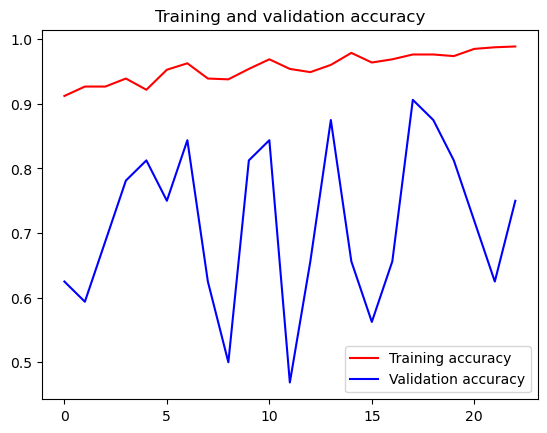

In [23]:
"""Funciones para graficar los history de validacion y el accuracy"""
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show()

In [24]:
"""Predicción del Modelo"""
y_pred = model.predict(x_test)

7/7 [==============================] - 9s 1s/step


In [25]:
"""Mostrar el array del y_pred"""
y_pred.round()

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [26]:
"""Visualizar las métricas del modelo"""
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred.round(), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.95      1.00      0.97        37
           2       0.73      0.96      0.83        28
           3       0.73      0.73      0.73        33
           4       0.90      0.50      0.64        36
           5       0.97      0.71      0.82        41
           6       0.47      1.00      0.64        17

   micro avg       0.81      0.82      0.81       221
   macro avg       0.82      0.84      0.80       221
weighted avg       0.85      0.82      0.81       221
 samples avg       0.81      0.81      0.81       221



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
"""Visualización del Accuracy"""
accuracy = model.evaluate(x_test,y_test,batch_size=32)
print("Accuracy: ",accuracy[1]*100)

7/7 [==============================] - 9s 1s/step - loss: 0.7694 - acc: 0.8125
Accuracy:  81.25


In [28]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

In [29]:
"""Reporte de clasificación de las métricas"""
report = classification_report(Y_true, Y_pred_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

      FASE 0       1.00      1.00      1.00        29
      FASE 1       1.00      0.95      0.97        39
      FASE 2       0.97      0.76      0.85        37
      FASE 3       0.73      0.73      0.73        33
      FASE 4       0.47      0.90      0.62        20
      FASE 5       0.71      0.97      0.82        30
      FASE 6       1.00      0.47      0.64        36

    accuracy                           0.81       224
   macro avg       0.84      0.82      0.80       224
weighted avg       0.87      0.81      0.81       224



 <h1><center> <font color='red'>Matriz de Confusión</font></center></h1> 

In [30]:
"""Estructurar la matriz de confusion"""
confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[29  0  0  0  0  0  0]
 [ 0 37  0  2  0  0  0]
 [ 0  0 28  6  2  1  0]
 [ 0  0  1 24  7  1  0]
 [ 0  0  0  0 18  2  0]
 [ 0  0  0  0  1 29  0]
 [ 0  0  0  1 10  8 17]]


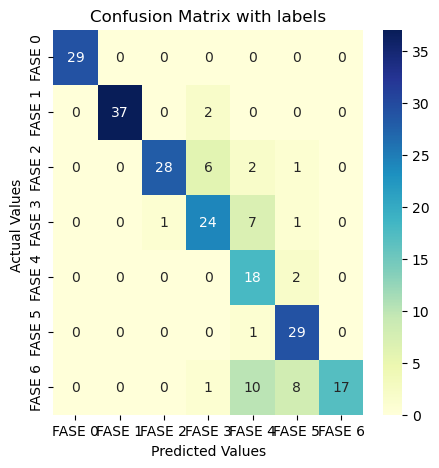

In [31]:
"""Librería para graficar la matriz de confusion"""
import seaborn as sns
plt.figure(figsize=(5, 5))

ma = sns.heatmap(confusion, cmap="YlGnBu", annot=True)
ma.set_title('Confusion Matrix with labels')
ma.set_xlabel('Predicted Values')
ma.set_ylabel('Actual Values ')
ma.xaxis.set_ticklabels(categories)
ma.yaxis.set_ticklabels(categories)

plt.show()

In [32]:
"""Crear un archivo de tipo json"""
model_json = model.to_json()
with open("CNN_TL_InceptionV3_Vocales_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("CNN_TL_InceptionV3_Vocales_Classifier.h5")
"""Guardar en el disco duro"""
print("Saved model to disk")
model.save_weights("CNN_TL_InceptionV3_Vocales.h5")

Saved model to disk
